## Aluno: Fernando Gomes Papi

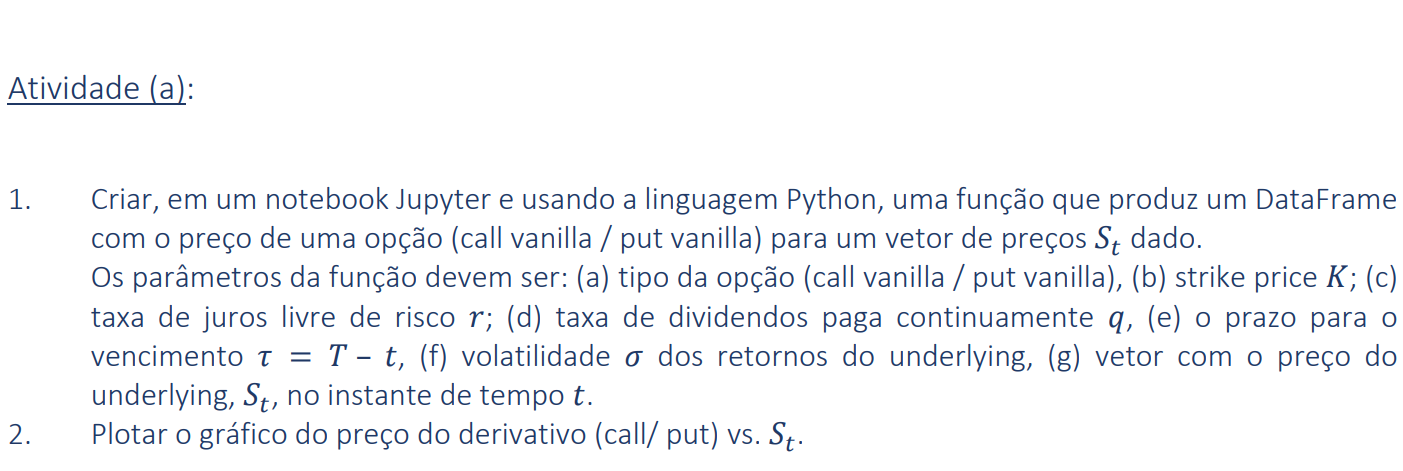

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [289]:
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import delta, gamma, vega, theta, rho

# Implementation of Black-Scholes formula in Python
import numpy as np
from scipy.stats import norm

def black_scholes_pricing_option(r, S, K, T, sigma, option_type, q):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r-q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == "call":
        price = np.exp(-r*T)* (S*np.exp((r-q)*T) * norm.cdf(d1, 0, 1) - K*norm.cdf(d2, 0, 1))
    
    elif option_type == "put":
        price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)

    return price

def pricing_options(option_type, K, r, q, tau, sigma, St):
    prices = {f'{option_type}': [black_scholes_pricing_option(r, S, K, T, sigma, option_type, q) for S in St]}
    return pd.DataFrame(prices, index=St)


In [ ]:
def portfolio_price(portolio, underlying_prices, r, q, sigma):
    # Função para calcular o payoff de uma opção de compra
    def call_pricing(call, underlying_price):
        option_type = call['type']
        K = call['K']
        tau = call['tau']
        value = black_scholes_pricing_option(r, underlying_price, K, tau, sigma, option_type, q)
        return value

    # Função para calcular o payoff de uma opção de venda
    def put_pricing(put, underlying_price):
        option_type = put['type']
        K = put['K']
        tau = put['tau']
        value = black_scholes_pricing_option(r, underlying_price, K, tau, sigma, option_type, q)
        return value

    def underlying_pricing(underlying, underlying_price):
        return underlying_price

    def forward_pricing(forward, underlying_price):
        tau = forward['tau']
        K = forward['K']
        value = underlying_price*np.exp(-q*tau) - K*np.exp(-r*tau)
        return value

    pricing_functions = {
        'call': call_pricing,
        'put': put_pricing,
        'underlying': underlying_pricing,
        'forward': forward_pricing
    }

    values = {}  # Dicionário para armazenar os valores
    
    for position in portfolio.values():
        position_type = position['type']
        pricing_f = pricing_functions[position_type]
        value = np.array([pricing_f(position, st) for st in underlying_prices])
        values[position_type] = value*position['size']
    
    # Cria um DataFrame a partir do dicionário de payoffs
    df = pd.DataFrame(values, index=underlying_prices)
    df['portfolio'] = df.sum(axis=1)
    
    return df


def plot_portfolio(portfolio_df, **kwargs):
        
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_df.index, portfolio_df[list(portfolio.keys())], label=list(portfolio.keys()), lw=2)
    plt.plot(portfolio_df.index, portfolio_df['portfolio'], label='portfolio', lw=4, ls='--', c='k')
    
    plt.xlabel(kwargs['xlabel'])
    plt.ylabel(kwargs['ylabel'])
    plt.title(kwargs['ylabel'])
    plt.legend()
    plt.grid(True)
    plt.show()


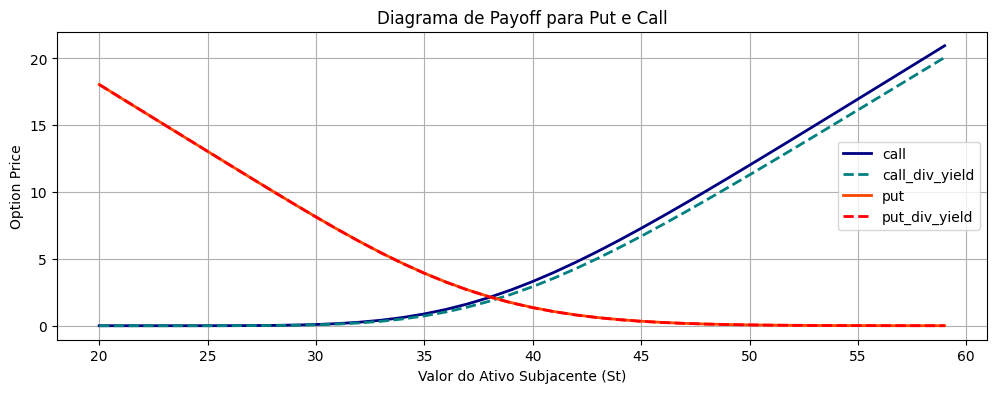

In [379]:
# Define variables - example from John Hull
St = np.arange(20, 60, 1)
r = 0.1
K = 40
T = 0.5
sigma = 0.2
div_yield = 0.03

option_type = 'call'
prices_call = pricing_options(option_type, K, r, q=0, tau=T, sigma=sigma, St=St)
prices_call_q = pricing_options(option_type, K, r, q=div_yield, tau=T, sigma=sigma, St=St)
# plot things

option_type = 'put'
prices_put = pricing_options(option_type, K, r, q=0, tau=T, sigma=sigma, St=St)
prices_put_q = pricing_options(option_type, K, r, q=div_yield, tau=T, sigma=sigma, St=St)

plt.figure(figsize=(12, 4))

plt.plot(prices.index, prices_call['call'], c='navy', lw=2, ls='-', label=f'call')
plt.plot(prices.index, prices_call_q['call'], c='teal', lw=2, ls='--', label=f'call_div_yield')

plt.plot(prices.index, prices_put['put'], c='orangered', lw=2, ls='-', label=f'put')
plt.plot(prices.index, prices_put_q['put'], c='red', lw=2, ls='--', label=f'put_div_yield')

plt.xlabel('Valor do Ativo Subjacente (St)')
plt.ylabel('Option Price')
plt.title(f'Diagrama de Payoff para Put e Call')
plt.legend()
plt.grid(True)

plt.show()

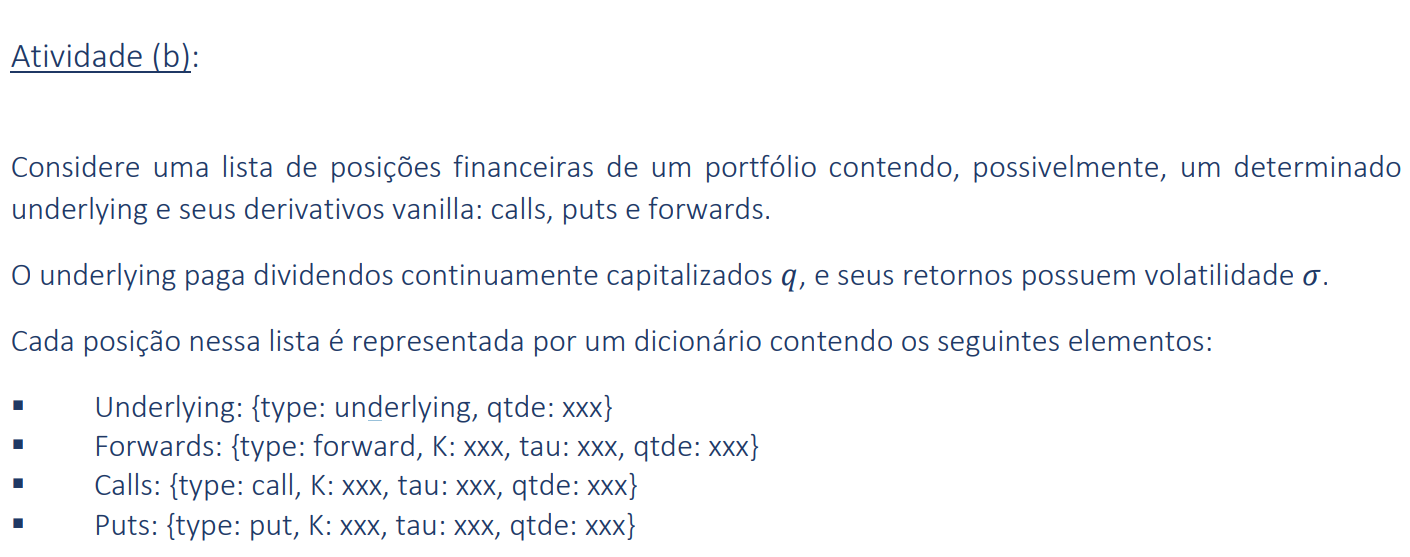
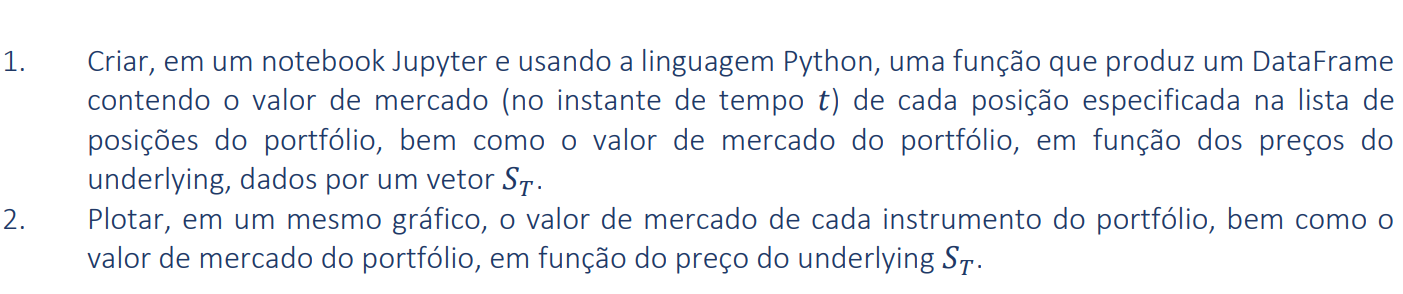

Ps.: Assumi que o forward foi iniciado a 1 período atrás (isso é, 2*T do vencimento do contrato) com o underlying a 38. O divident_yield (q) desse ativo coloquei 3%. O resto dos valores usei o exemplo do livro do John Hull

In [380]:
# Define variables - example from John Hull (and div yield q = 0.03)
St = np.arange(25, 75, 1)
S0 = 42
r = 0.1
K = 40
T = 0.5
sigma = 0.2
div_yield = 0.03

forward_price = S0*np.exp(r*T)
forward_price

portfolio = {
    'underlying': {'type': 'underlying', 'size': 10},
    'forward': {'type': 'forward', 'K': 38*np.exp(r*T*2), 'tau':T, 'size': 5},
    'call': {'type': 'call', 'K': K, 'tau':T, 'size': 10},
    'put': {'type': 'put', 'K': K, 'tau':T, 'size': 12}
}

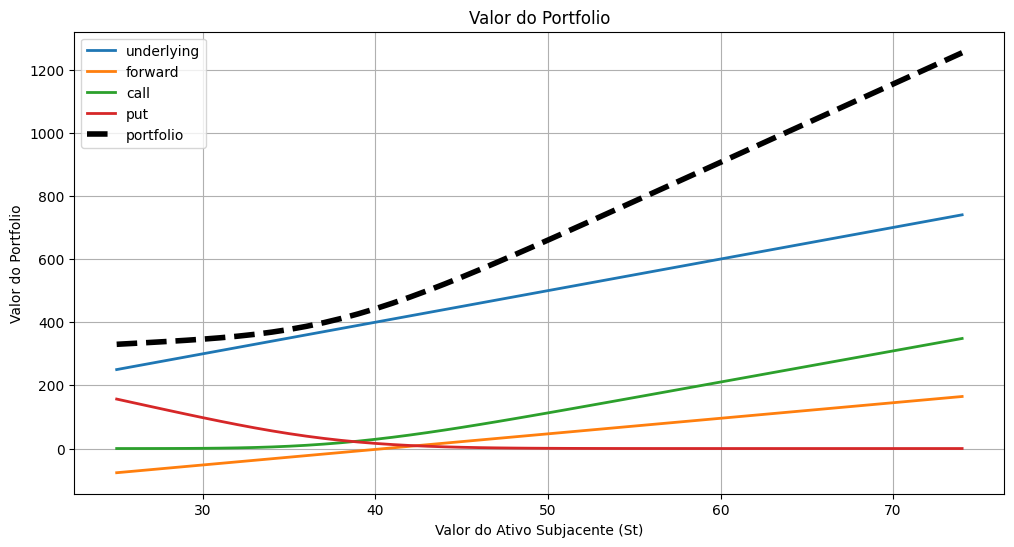

In [381]:
portfolio_value_df = portfolio_price(portfolio, St, r, q=div_yield, sigma=sigma)

kwargs = {'xlabel': 'Valor do Ativo Subjacente (St)',
          'ylabel': 'Valor do Portfolio'
         }

plot_portfolio(portfolio_value_df, **kwargs)

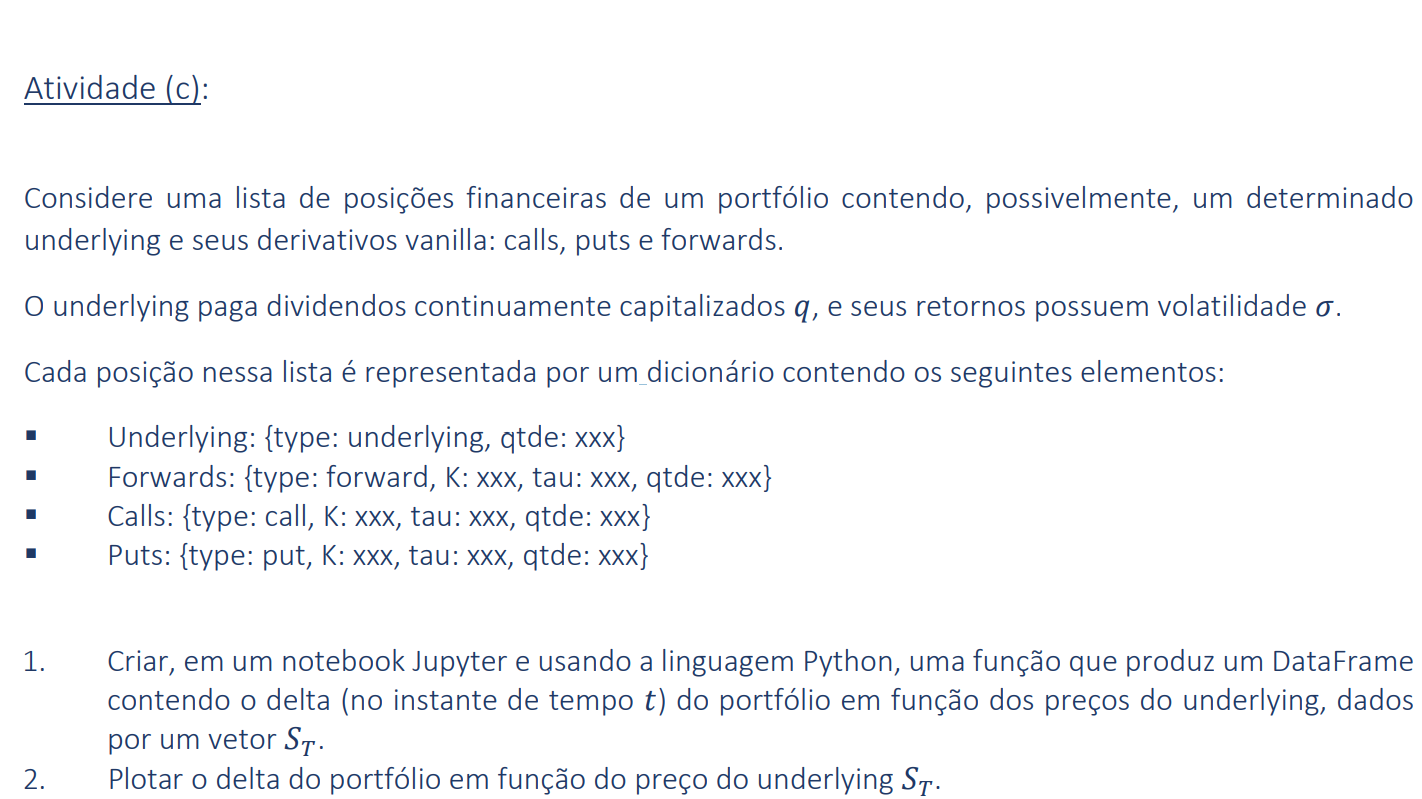

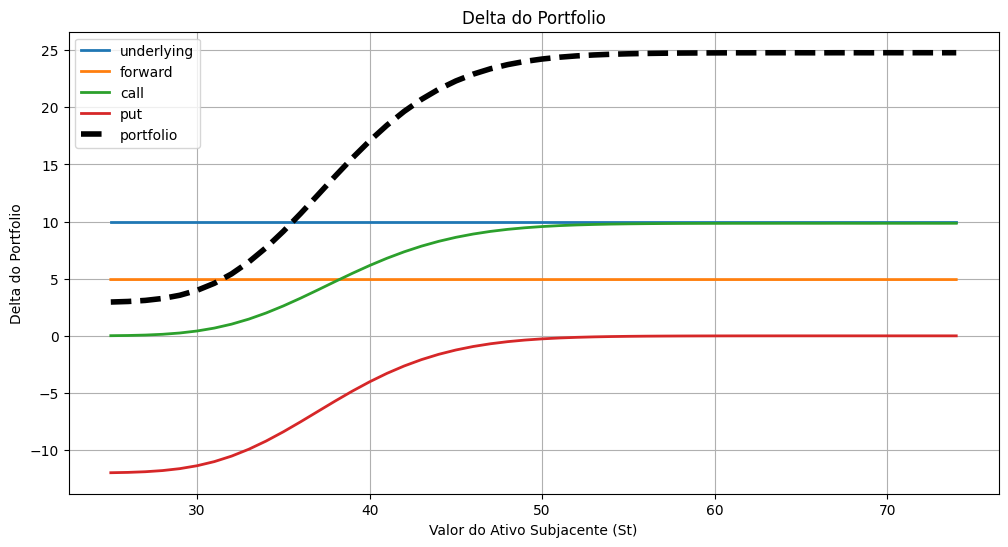

In [382]:
def portfolio_delta(portfolio, underlying_prices, r, q, sigma, dp=1e-10):
    deltas = []

    for S in underlying_prices:
        prices = [S-0.5*dp, S+0.5*dp]
        delta_price = portfolio_price(portfolio, prices, r, q, sigma)
        delta_price = delta_price.diff().dropna()/dp
        delta_price.index = [S]
        deltas.append(delta_price)

    delta_df = pd.concat(deltas)
    return delta_df

portfolio_delta_df = portfolio_delta(portfolio, St, r, div_yield, sigma)

kwargs = {'xlabel': 'Valor do Ativo Subjacente (St)',
          'ylabel': 'Delta do Portfolio'
         }

plot_portfolio(portfolio_delta_df, **kwargs)

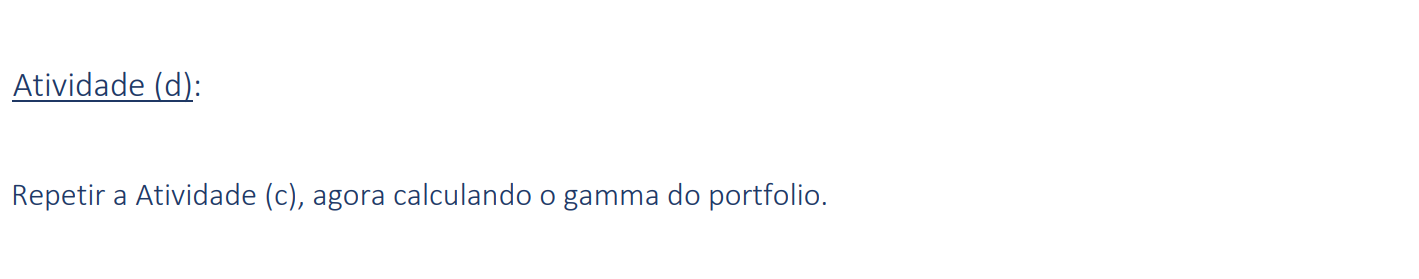

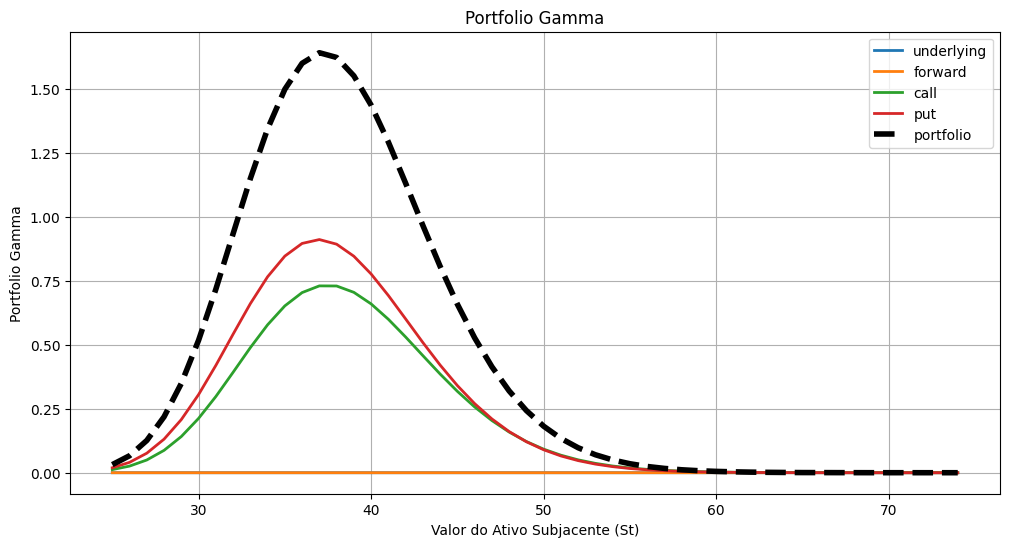

In [383]:
def portfolio_gamma(portfolio, underlying_prices, r, q, sigma, dp=1e-4):
    gammas = []

    for S in underlying_prices:
        prices = [S-dp, S, S+dp]
        gamma_price = portfolio_price(portfolio, prices, r, q, sigma)
        gamma_price.index = ['-dp', '0', '+dp']
        gamma_price = gamma_price.apply(lambda x: (x['-dp'] - 2*x['0'] + x['+dp'])/(dp**2)).to_frame().T
        gamma_price.index = [S]
        gammas.append(gamma_price)

    gamma_df = pd.concat(gammas)
    return gamma_df

portfolio_gamma_df = portfolio_gamma(portfolio, St, r, div_yield, sigma)

kwargs = {'xlabel': 'Valor do Ativo Subjacente (St)',
          'ylabel': 'Portfolio Gamma'
         }
plot_portfolio(portfolio_gamma_df, **kwargs)

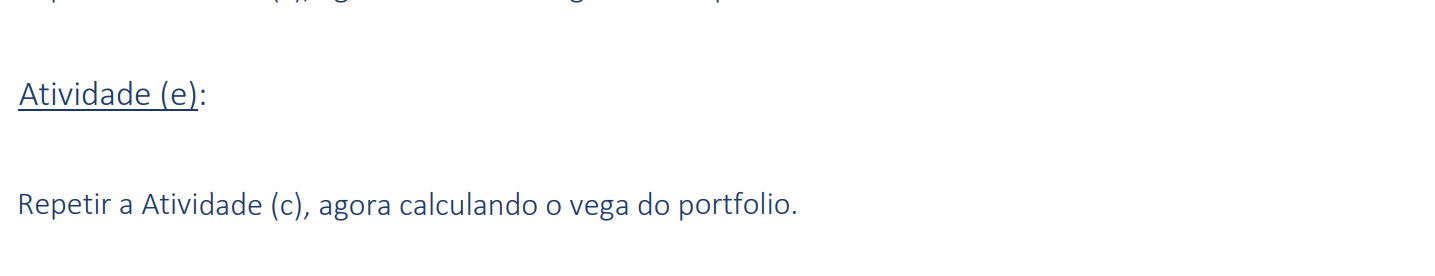

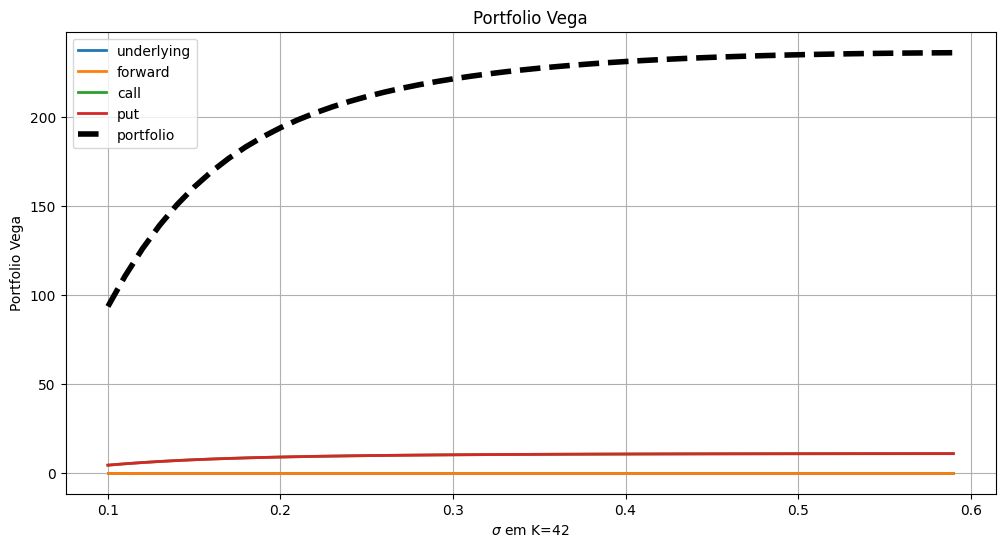

In [395]:
volatilities = np.arange(0.1, 0.6, 0.01)

def vega_calc(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    vega = S*norm.pdf(d1, 0, 1)*np.sqrt(T)
    return vega 

def portfolio_vega(portfolio, volatility_list, r, K, S, T, q, ds=1e-4):
    vegas = []
    
    for sigma in volatility_list:

        vega = vega_calc(S, K, r, sigma, T)
        vega = {'underlying':0, 'forward': 0, 'call': vega, 'put': vega}
        vegas.append(vega)

    vega_df = pd.DataFrame(vegas, index=volatility_list)
    return vega_df

portfolio_vega_df = portfolio_vega(portfolio, volatilities, r, K, S=S0, T=T, q=div_yield)
portfolio_vega_df['portfolio'] = portfolio_vega_df['call']*portfolio['call']['size'] + portfolio_vega_df['put']*portfolio['put']['size']

kwargs = {'xlabel': f'$\sigma$ em K={S0}',
          'ylabel': 'Portfolio Vega'
         }
plot_portfolio(portfolio_vega_df, **kwargs)